# DSC 500 Data Science Capstone | Fall 2024
- Project by data science major _Arthur Melo_
- Data science advisor: Dr. Jeffrey Heath

## What is this project about?

This project delves into the intricate world of supply chain optimization, utilizing predictive analytics to enhance decision-making in logistics. By harnessing the power of data science, the project aims to achieve the following objectives:

- Predict the risk of late deliveries, empowering businesses to take proactive measures and mitigate potential disruptions in their supply chain operations.
- Uncover actionable insights that drive targeted improvements in logistics, leading to increased efficiency, reduced costs, and enhanced customer satisfaction.

The project's core revolves around the analysis of the "DataCo SMART Supply Chain" dataset, a comprehensive collection of 180,000 transactions meticulously documented across 53 columns. This dataset serves as the bedrock for exploration, enabling the identification of key factors that contribute to late deliveries.

Through a series of rigorous steps, including data cleaning, exploratory data analysis (EDA), feature engineering, and predictive modeling, the project seeks to illuminate the complex dynamics within the supply chain.

The ultimate goal is to equip businesses with a robust predictive model and actionable recommendations to streamline their shipping processes, optimize resource allocation, and foster a more resilient and responsive supply chain.

In [2]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set visual style for plots
sns.set(style="whitegrid")


In [3]:
# Load the dataset (adjust the file path if necessary)
data_path = 'DataCoSupplyChainDataset.csv'
data = pd.read_csv(data_path, encoding='latin1')

# View the first few rows of the data to understand its structure
data.head()

# Check the shape of the dataset
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

Number of rows: 180519, Number of columns: 53


In [3]:
# Summary statistics of the numerical columns
print(data.describe())

# Check for missing values in the dataset
print(data.isnull().sum())


       Days for shipping (real)  Days for shipment (scheduled)  \
count             180519.000000                  180519.000000   
mean                   3.497654                       2.931847   
std                    1.623722                       1.374449   
min                    0.000000                       0.000000   
25%                    2.000000                       2.000000   
50%                    3.000000                       4.000000   
75%                    5.000000                       4.000000   
max                    6.000000                       4.000000   

       Benefit per order  Sales per customer  Late_delivery_risk  \
count      180519.000000       180519.000000       180519.000000   
mean           21.974989          183.107609            0.548291   
std           104.433526          120.043670            0.497664   
min         -4274.979980            7.490000            0.000000   
25%             7.000000          104.379997            0.000000 

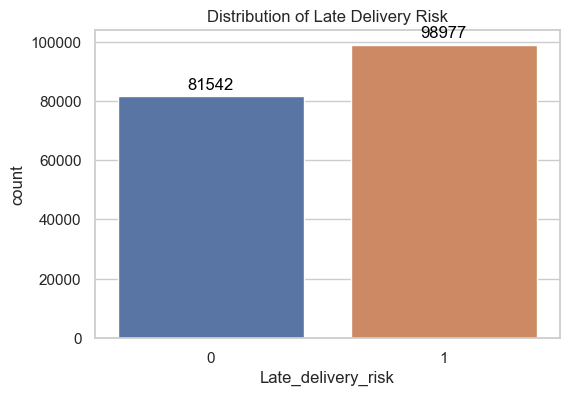

In [4]:
# Plot the distribution of Late_delivery_risk with labels
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Late_delivery_risk', data=data)
plt.title('Distribution of Late Delivery Risk')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

/var/folders/rg/lg_tz_7113s8g_cnn_2qv6w40000gn/T/ipykernel_54664/2205155934.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Shipping Mode'] = filtered_data['Shipping Mode'].astype('category').cat.codes


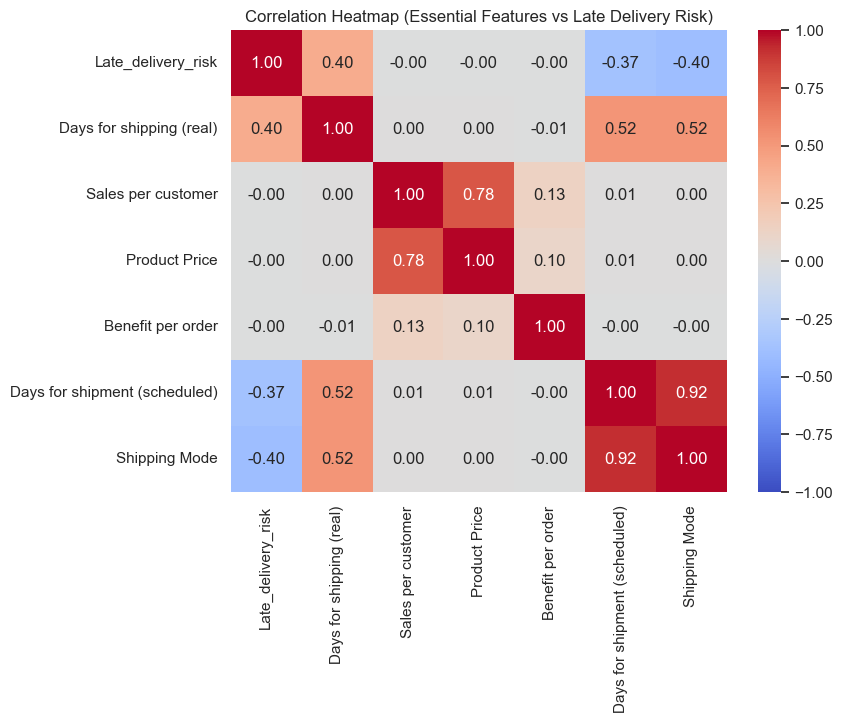

In [5]:
# Select essential features for correlation
essential_features = ['Late_delivery_risk', 'Days for shipping (real)', 'Sales per customer', 
                      'Product Price', 'Benefit per order', 'Days for shipment (scheduled)', 
                      'Shipping Mode']

# Filter the dataframe to only include these essential features
filtered_data = data[essential_features]

# Convert Shipping Mode to numerical values for correlation analysis
filtered_data['Shipping Mode'] = filtered_data['Shipping Mode'].astype('category').cat.codes

# Calculate the correlation matrix for essential features
corr_matrix_filtered = filtered_data.corr()

# Generate the heatmap for essential features
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Essential Features vs Late Delivery Risk)')
plt.show()


In [6]:
# Handling missing data

# Drop rows where Customer Lname is missing
data_cleaned = data.dropna(subset=['Customer Lname'])


In [7]:
# Drop rows where Customer Lname is missing
data_cleaned = data.dropna(subset=['Customer Lname'])

# Drop rows where Customer Zipcode is missing
data_cleaned = data_cleaned.dropna(subset=['Customer Zipcode'])

# Drop the Order Zipcode column
data_cleaned = data_cleaned.drop(columns=['Order Zipcode'])

# Drop the Product Description column
data_cleaned = data_cleaned.drop(columns=['Product Description'])

Since only 8 values are missing, and the Customer Lname feature is likely non-essential for our analysis, so we can  drop the 8 rows becaue doing so won’t significantly affect the dataset with 180K rows in total. Similarly, we can drop Customer Zipcode.

On the other hand, there's lots of missing data for order zipcode, but since we already have other region-grain features for orders (order city, country), I chose to not go to the zip code location grain and leverage the other features with non-empty values.

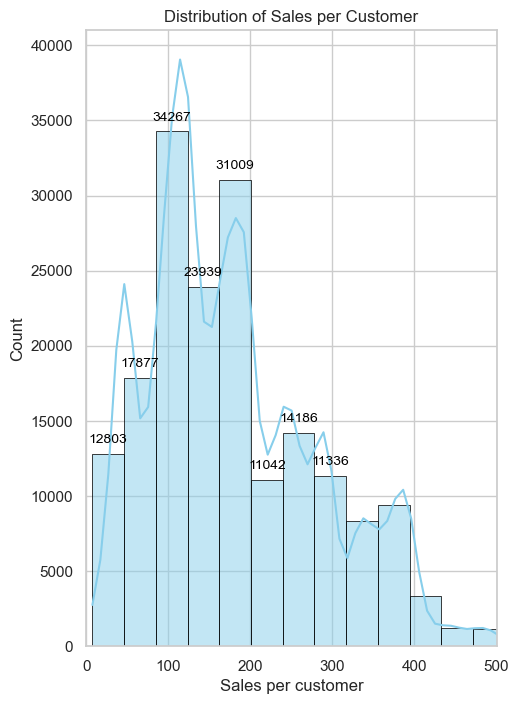

In [8]:
# Plot distribution of key features with improved visibility
plt.figure(figsize=(18, 8))  # Keep larger figure size

# Sales per customer
plt.subplot(1, 3, 1)
ax1 = sns.histplot(data['Sales per customer'], kde=True, bins=50, color="skyblue", edgecolor='black')  # Increased bins for granularity, adjusted colors
plt.title('Distribution of Sales per Customer')

# Set x-axis limit to focus on the data range where most values are concentrated
plt.xlim(0, 500)

# Add labels to major peaks (threshold to only show significant bars)
threshold = 10000  # Adjust based on the data; it determines what counts as a 'major peak'
for p in ax1.patches:
    height = p.get_height()
    if height > threshold:  # Only annotate bars with height greater than the threshold
        ax1.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 8),  # Slightly increase the offset for better readability
                     textcoords='offset points')

plt.show()


- Plot Overview: This histogram with a KDE (Kernel Density Estimate) plot shows the distribution of "Sales per Customer" values in the dataset. It allows us to see both the frequency of sales in different ranges and the overall shape of the data's distribution.

Major Peaks:

- The highest peak is around 100 dollars in sales, with approximately 34,267 instances.
There are significant peaks at 50 dollars and 150 dollars, with counts of 17,877 and 31,009, respectively.
Sales Distribution:

- Most sales per customer fall between 0 dollars and 200 dollars, with a heavy concentration between 50 dollars and 150 dollars.
As the sales amount increases beyond 200 dollars, the frequency of occurrences gradually declines.
Sales Tail:

- Sales above 400 dollars become increasingly rare, with very few customers contributing to those higher sales amounts.

KDE Line:

- The smooth KDE line overlays the histogram to show the probability density of sales per customer, giving us an overall trend of how the data is distributed.
Granularity:

- The bins and KDE provide granularity, allowing us to observe not just the peaks but also the smaller fluctuations in the data between the main sales ranges.

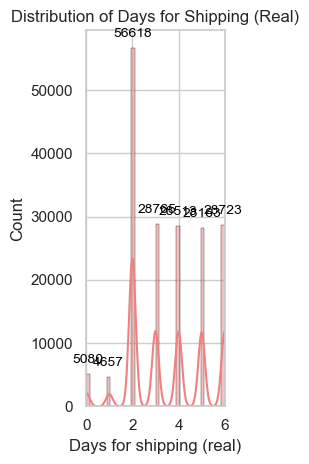

In [9]:
# Days for shipping (real) with improved visibility
plt.subplot(1, 3, 2)
ax2 = sns.histplot(data['Days for shipping (real)'], kde=True, bins=40, color='lightcoral', edgecolor='black')  # Increased bins and adjusted colors
plt.title('Distribution of Days for Shipping (Real)')

# Set x-axis limit to focus on the most common values
plt.xlim(0, 6)

# Add labels to major peaks (threshold to only show significant bars)
threshold = 2000  # Adjust this value based on the data; it determines what counts as a 'major peak'
for p in ax2.patches:
    height = p.get_height()
    if height > threshold:  # Only annotate bars with height greater than the threshold
        ax2.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 8),  # Slightly increase the offset for readability
                     textcoords='offset points')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

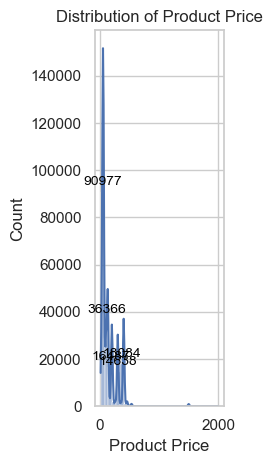

In [10]:
# Product Price
plt.subplot(1, 3, 3)
ax3 = sns.histplot(data['Product Price'], kde=True, bins=30)  # Adjust bins for better distribution
plt.title('Distribution of Product Price')

# Add labels to major peaks (threshold to only show significant bars)
threshold = 5000  # Adjust this value based on the data; it determines what counts as a 'major peak'
for p in ax3.patches:
    height = p.get_height()
    if height > threshold:  # Only annotate bars with height greater than the threshold
        ax3.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()


## Shipping mode preview

The dataset descriptions indicate that the "Shipping Mode" field contains four different modes of shipping, which can help interpret the logistics of how products are delivered. Here's a breakdown of what each shipping mode likely implies:

Standard Class:

This is the most common and probably the slowest and least expensive shipping option. It is often chosen for non-urgent deliveries. Given its lower cost, it may have more relaxed delivery time expectations, leading to a higher chance of late delivery risks.

First Class:

A faster, more reliable option than Standard Class. First Class shipping generally comes at a higher cost but promises quicker delivery times. Even so, depending on the shipping provider and region, this method may still experience delays, especially if volume spikes.


Second Class:

This shipping mode likely falls between Standard and First Class in terms of speed and cost. It could be a more affordable, middle-ground option, possibly chosen when delivery speed is important but not urgent.

Same Day:

The fastest and most expensive shipping method, intended for urgent deliveries. This mode is used when the order needs to arrive on the same day it is placed. However, Same Day delivery can still face logistical challenges (e.g., traffic, stock availability), which may lead to late deliveries despite the high expectations.
Implications for Analysis:
Standard Class: Expect more late deliveries due to slower shipping and fewer resources dedicated to speed.
First Class: Fewer late deliveries than Standard Class, but there may still be cases of delays.
Second Class: Possibly higher risk than First Class but lower than Standard Class, with a balance between cost and delivery time.

Same Day: While this method promises fast delivery, there may be a higher likelihood of operational failures leading to delays, despite the urgency.

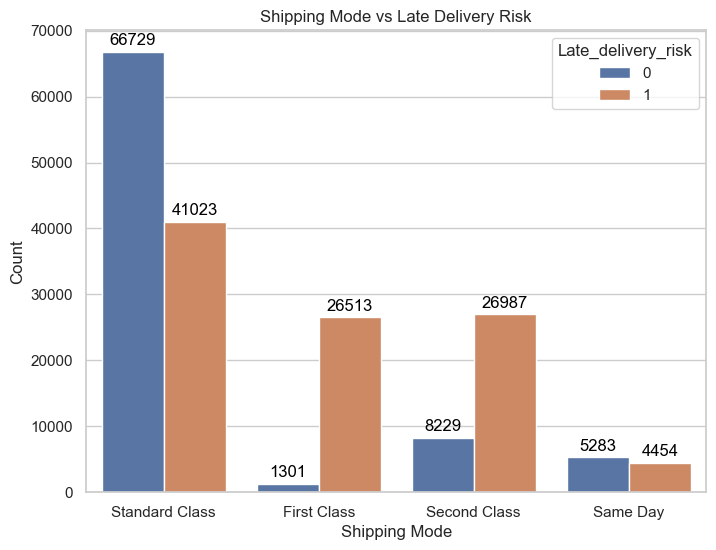

In [11]:
# Plot the distribution of Shipping Mode vs Late Delivery Risk
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Shipping Mode', hue='Late_delivery_risk', data=data)
plt.title('Shipping Mode vs Late Delivery Risk')
plt.ylabel('Count')

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

- This plot shows the distribution of Late Delivery Risk across different Shipping Modes.
- We can observe that Standard Class has a higher count of late deliveries compared to other modes

**Key Observations:**

Standard Class:

- A large number of orders (66,729) were shipped using Standard Class without a late delivery risk (0).
- However, a significant portion of Standard Class shipments (41,023) faced a late delivery risk (1).
- Insight: Standard Class has the highest overall volume of orders, but also seems to have a relatively higher incidence of late deliveries. This could be due to longer shipping times or the nature of this shipping mode being less reliable for on-time delivery.

First Class:

- First Class shipments with no late delivery risk are quite low (only 1,301 orders).
- In contrast, 26,513 orders shipped via First Class have a late delivery risk (1).
- Insight: First Class has a disproportionately high rate of late delivery risk relative to its total shipment volume. This indicates that despite its name, First Class might not be the most reliable for on-time deliveries in this dataset.

Second Class:

- 8,229 orders were shipped using Second Class without a late delivery risk, while 26,987 orders faced a late delivery risk.
- Insight: Like First Class, Second Class shipments have a higher proportion of late delivery risks. This mode also seems relatively unreliable when compared to Standard Class.

Same Day:

- The Same Day shipping mode has the smallest number of orders overall. 5,283 orders were delivered on time, while 4,454 orders faced a late delivery risk.
- Insight: While Same Day deliveries should theoretically be the most reliable for on-time delivery, the almost equal number of late and on-time deliveries suggests that Same Day shipping is not immune to delays. This could indicate logistical challenges in fulfilling Same Day deliveries.

General Insights:

- Standard Class: Despite having the most volume, Standard Class has a considerable number of late delivery risks. - However, it still shows the best proportion of on-time deliveries compared to other classes.
- First and Second Class: Both of these shipping modes seem particularly prone to late deliveries, as the number of late deliveries vastly outweighs the on-time deliveries.
- Same Day: Although this shipping method is meant for fast deliveries, its late delivery risk is surprisingly high, raising questions about logistical limitations.

Takeaways for Model Building:
- Shipping Mode seems to be an important feature in predicting late delivery risk. In particular, First Class and - Second Class are likely to be strong indicators of late deliveries, while Same Day and Standard Class might be less reliable but still informative.
- We might want to consider Shipping Mode in combination with other variables like Days for shipping (real) to build a more accurate prediction model.

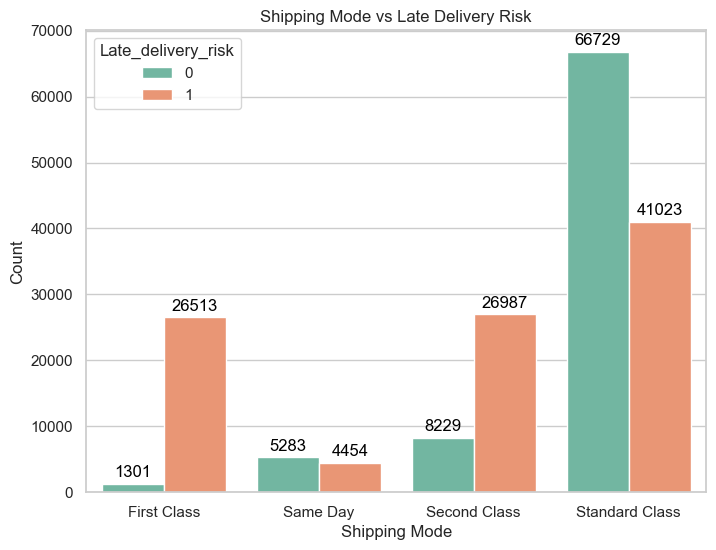

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total counts for each shipping mode and late delivery risk
data_grouped = data.groupby(['Shipping Mode', 'Late_delivery_risk']).size().reset_index(name='Count')

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Shipping Mode', y='Count', hue='Late_delivery_risk', data=data_grouped, palette="Set2")
plt.title('Shipping Mode vs Late Delivery Risk')
plt.ylabel('Count')

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()


- First class: 95.32% of orders were late (orange delivery risk or late_delivery_risk = 1). That was supposed to be the best class, but oddly it has a high rate of late deliveries
- Same day: 45.74% of orders were late. Not as bad as first-class, but it shows that more than half the time the business cannot deliver on its promise to take orders to clients on the same day
- Second class: 76.63% of orders were late -- surprisingly lower than first class
- Standard class: 38.07% of orders were late -- definitely the best performing class

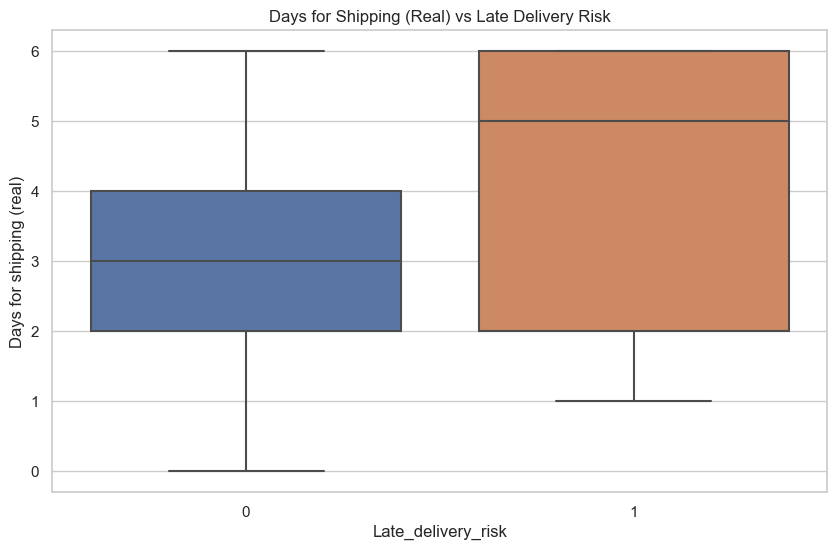

In [13]:
# Boxplot for Days for Shipping (Real) vs Late Delivery Risk
plt.figure(figsize=(10, 6))
sns.boxplot(x='Late_delivery_risk', y='Days for shipping (real)', data=data)
plt.title('Days for Shipping (Real) vs Late Delivery Risk')
plt.show()

- This boxplot visualizes the relationship between real shipping days and Late Delivery Risk.
- Orders with late delivery risk (Late_delivery_risk = 1) tend to have more days for actual shipping, which could be a significant factor in delays.

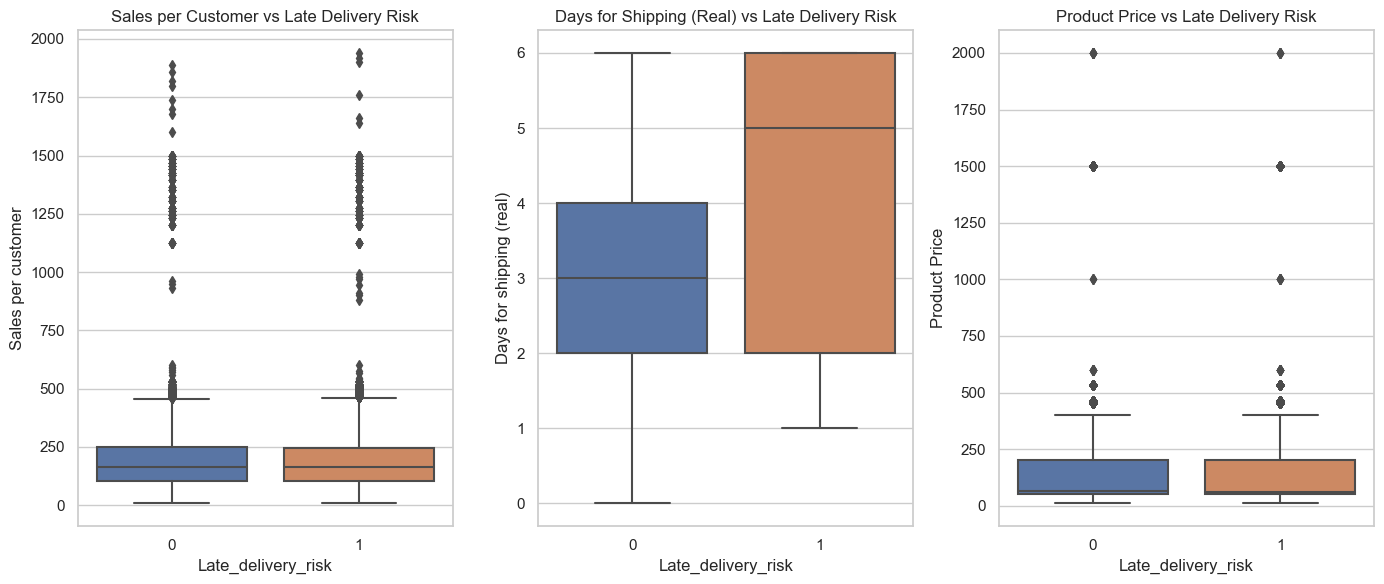

In [14]:
# Box plots for key numerical features
plt.figure(figsize=(14,6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Late_delivery_risk', y='Sales per customer', data=data)
plt.title('Sales per Customer vs Late Delivery Risk')

plt.subplot(1, 3, 2)
sns.boxplot(x='Late_delivery_risk', y='Days for shipping (real)', data=data)
plt.title('Days for Shipping (Real) vs Late Delivery Risk')

plt.subplot(1, 3, 3)
sns.boxplot(x='Late_delivery_risk', y='Product Price', data=data)
plt.title('Product Price vs Late Delivery Risk')

plt.tight_layout()
plt.show()


In [15]:
# Create the 'Shipping Delay' variable
data['Shipping_Delay'] = data['Days for shipment (scheduled)'] - data['Days for shipping (real)']

# Explanation:
# Positive values indicate a delay.
# Negative values indicate early deliveries (delivered earlier than scheduled).
# Zero means the shipment was delivered on time.

# Check the first few rows to ensure the new column is created correctly
print(data[['Days for shipment (scheduled)', 'Days for shipping (real)', 'Shipping_Delay']].head())


   Days for shipment (scheduled)  Days for shipping (real)  Shipping_Delay
0                              4                         3               1
1                              4                         5              -1
2                              4                         4               0
3                              4                         3               1
4                              4                         2               2


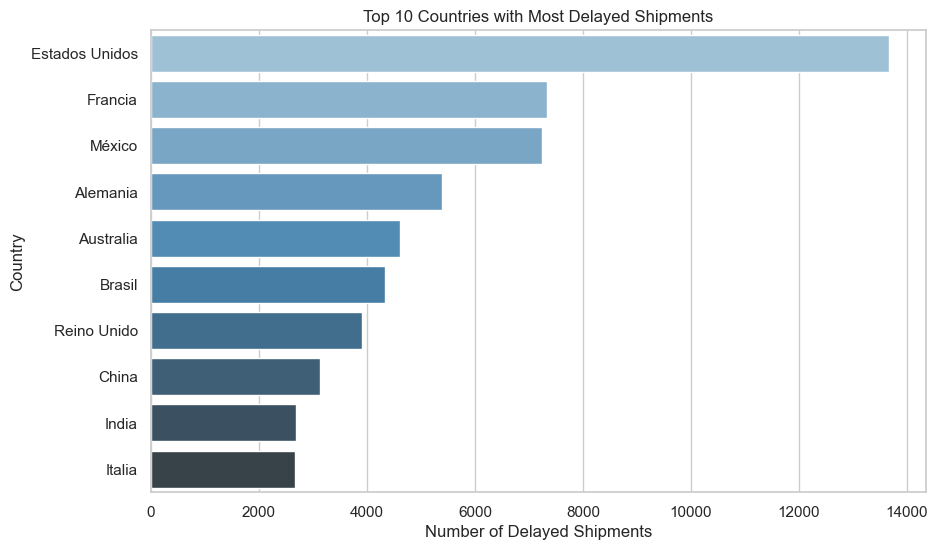

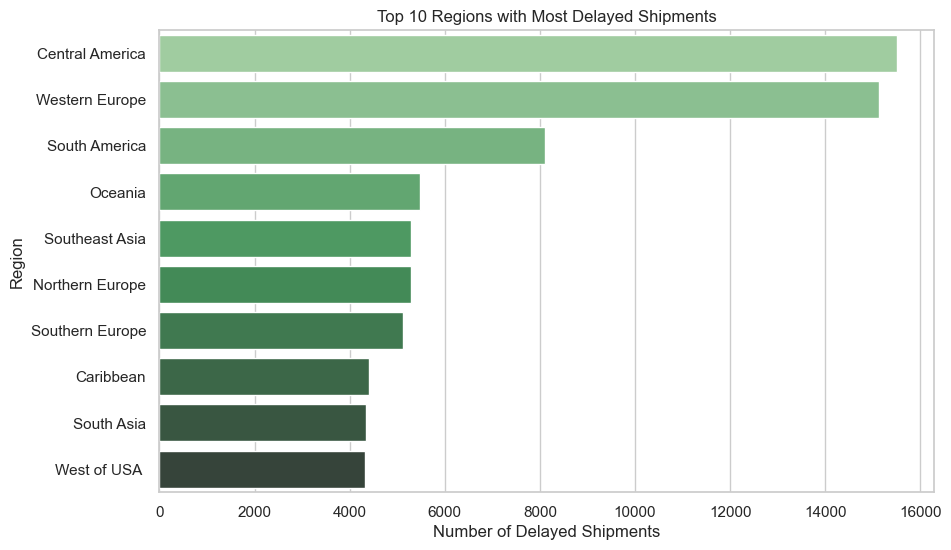

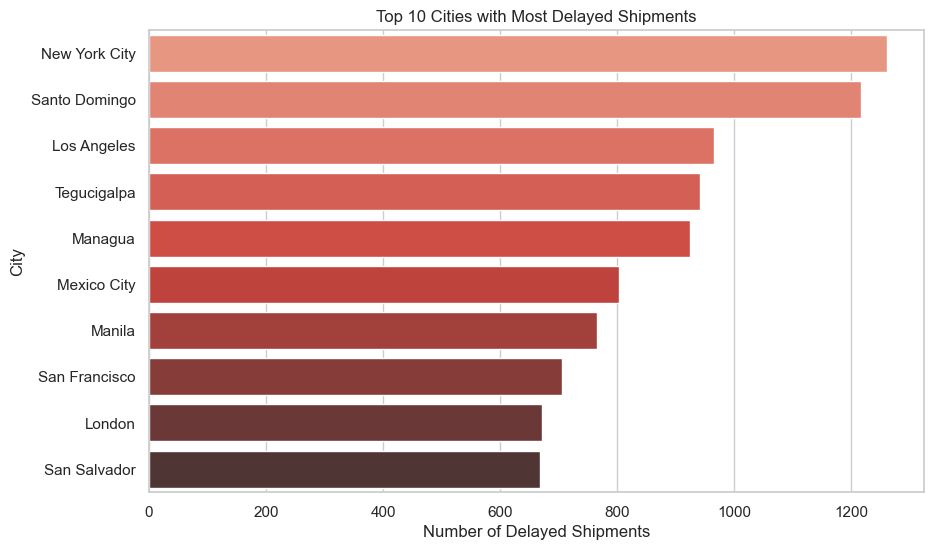

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


# Group by 'Order Country' and sum up the number of delayed shipments
top_countries = data_cleaned[data_cleaned['Late_delivery_risk'] == 1].groupby('Order Country').size().nlargest(10)

# Group by 'Order Region' and sum up the number of delayed shipments
top_regions = data_cleaned[data_cleaned['Late_delivery_risk'] == 1].groupby('Order Region').size().nlargest(10)

# Group by 'Order City' and sum up the number of delayed shipments
top_cities = data_cleaned[data_cleaned['Late_delivery_risk'] == 1].groupby('Order City').size().nlargest(10)


# Plot top 10 countries with the most delayed shipments
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="Blues_d")
plt.title("Top 10 Countries with Most Delayed Shipments")
plt.xlabel("Number of Delayed Shipments")
plt.ylabel("Country")
plt.show()

# Plot top 10 regions with the most delayed shipments
plt.figure(figsize=(10,6))
sns.barplot(x=top_regions.values, y=top_regions.index, palette="Greens_d")
plt.title("Top 10 Regions with Most Delayed Shipments")
plt.xlabel("Number of Delayed Shipments")
plt.ylabel("Region")
plt.show()

# Plot top 10 cities with the most delayed shipments
plt.figure(figsize=(10,6))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="Reds_d")
plt.title("Top 10 Cities with Most Delayed Shipments")
plt.xlabel("Number of Delayed Shipments")
plt.ylabel("City")
plt.show()


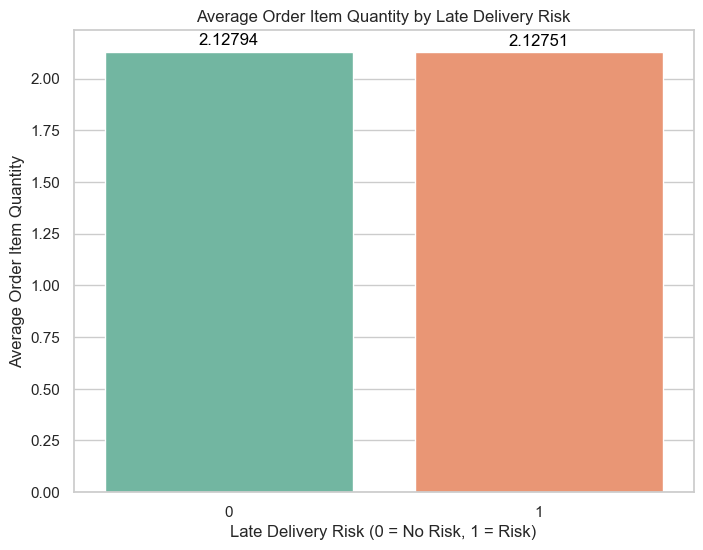

In [17]:
# Calculate the average Order Item Quantity for each Late Delivery Risk category
order_quantity_risk = data_cleaned.groupby('Late_delivery_risk')['Order Item Quantity'].mean()


# Plot the relationship between Late Delivery Risk and Order Item Quantity
plt.figure(figsize=(8,6))
ax = sns.barplot(x=order_quantity_risk.index, y=order_quantity_risk.values, palette="Set2")

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.5f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.title("Average Order Item Quantity by Late Delivery Risk")
plt.xlabel("Late Delivery Risk (0 = No Risk, 1 = Risk)")
plt.ylabel("Average Order Item Quantity")
plt.show()

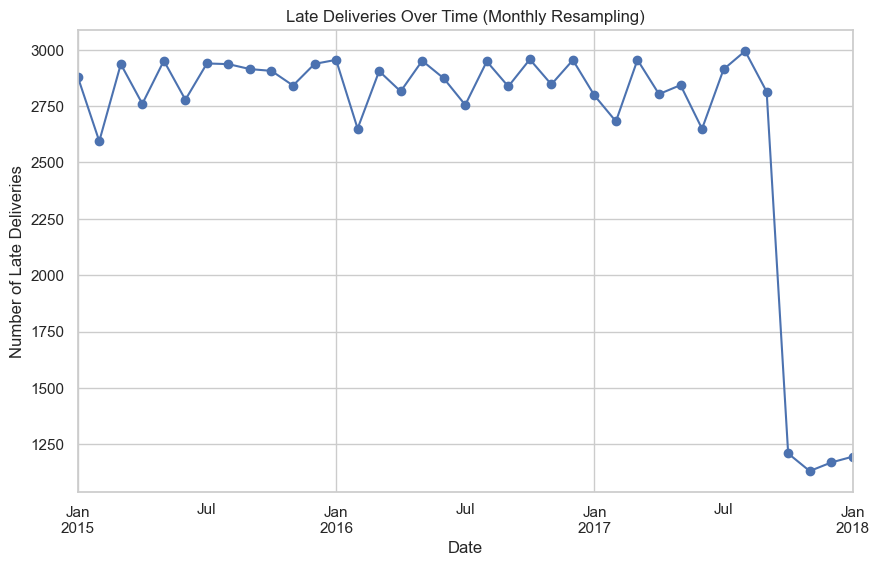

In [18]:
# Ensure that 'order date (DateOrders)' is in datetime format
data_cleaned['order date (DateOrders)'] = pd.to_datetime(data_cleaned['order date (DateOrders)'])

# Filter for late deliveries and group by order date
late_deliveries_time_series = data_cleaned[data_cleaned['Late_delivery_risk'] == 1].groupby('order date (DateOrders)').size()

# Resample the data to a monthly time frame and sum the number of late deliveries
late_deliveries_resampled = late_deliveries_time_series.resample('M').sum()


# Resample the data to a weekly time frame
late_deliveries_resampled = late_deliveries_time_series.resample('M').sum()

# Plot the resampled time series (weekly)
plt.figure(figsize=(10,6))
late_deliveries_resampled.plot(kind='line', marker='o', linestyle= '-', color='b')
plt.title("Late Deliveries Over Time (Monthly Resampling)")
plt.xlabel("Date")
plt.ylabel("Number of Late Deliveries")
plt.grid(True)
plt.show()

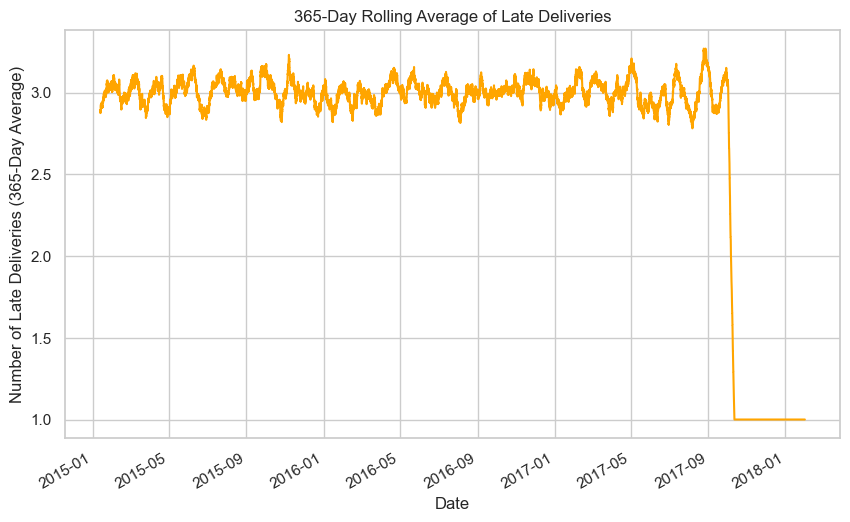

In [19]:
# Calculate a 30-day rolling average of late deliveries
rolling_avg = late_deliveries_time_series.rolling(window=365).mean()

# Plot the rolling average of late deliveries
plt.figure(figsize=(10,6))
rolling_avg.plot(kind='line', color='orange')
plt.title("365-Day Rolling Average of Late Deliveries")
plt.xlabel("Date")
plt.ylabel("Number of Late Deliveries (365-Day Average)")
plt.grid(True)
plt.show()
# Check if there is a drop in total orders around the same time
total_orders_time_series = data_cleaned.groupby('order date (DateOrders)').size()

# Resample the data to a weekly time frame and sum the total number of orders
total_orders_resampled = total_orders_time_series.resample('W').sum()


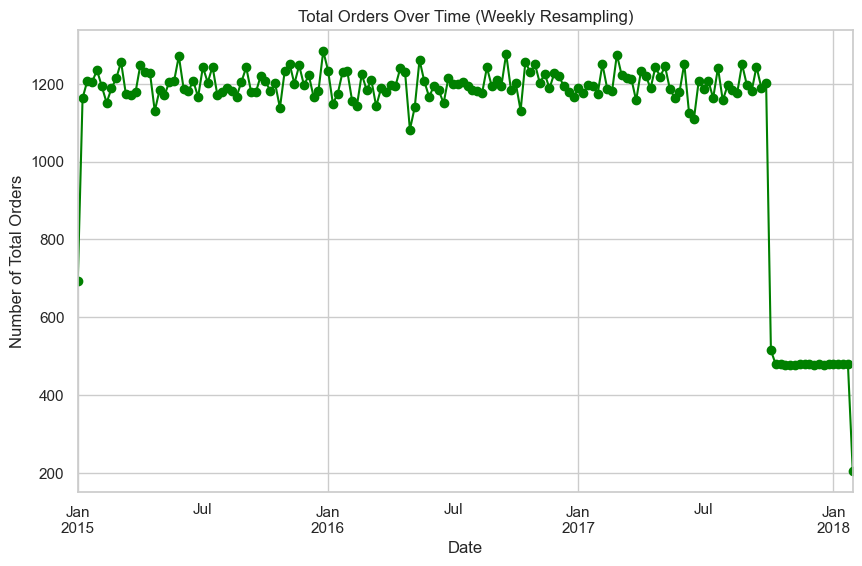

In [20]:
# Check if there is a drop in total orders around the same time
# Use the correct column name: 'order date (DateOrders)'
total_orders_time_series = data_cleaned.groupby('order date (DateOrders)').size()

# Resample the data to a weekly time frame and sum the total number of orders
total_orders_resampled = total_orders_time_series.resample('W').sum()

# Plot the total number of orders over time
plt.figure(figsize=(10,6))
total_orders_resampled.plot(kind='line', marker='o', linestyle='-', color='green')
plt.title("Total Orders Over Time (Weekly Resampling)")
plt.xlabel("Date")
plt.ylabel("Number of Total Orders")
plt.grid(True)
plt.show()


In [21]:
# Check the range of dates in the dataset
print("Data range:", data['order date (DateOrders)'].min(), "to", data['order date (DateOrders)'].max())

Data range: 1/1/2015 0:00 to 9/9/2017 9:50


## Sharp drop in delivery data and development decisions before forecasting

It would make sense to proceed with a time series forecast, but with caution regarding that sharp drop. The sharp decrease at the end of both graphs is likely a data quality issue or an incomplete data collection period, as it does not reflect typical trends seen earlier in the time series. Ignoring this outlier while creating a forecasting model, such as ARIMA or exponential smoothing, would yield more accurate predictions based on the more stable period of data.

To handle this, we could:

- Filter Out the Fluke: Exclude the portion of the data that shows the sudden drop. This can be done by truncating the time series up to the point where the trend is still consistent and reliable.

- Create a Model for Forecasting: Implement a time series model, such as ARIMA, using the truncated data. We can use the stable period before the anomaly to forecast future late deliveries or total orders. Here's a general flow:

- Preprocess the data, ensuring it's stationary if necessary (differencing, removing trend, etc.).
- Fit the ARIMA model to the reliable period.
- Forecast future values and assess the model performance using holdout samples.
- Examine Seasonality and Trends: Given the relatively stable patterns before the drop, you could also incorporate seasonality into the model, if needed, to capture recurring patterns in late deliveries.

By excluding the drop and focusing on the consistent trends, you can build a more reliable forecast model for late deliveries or total orders over time.

#### Possible reasons behind the sharp drop in the number of total orders and number of deliveries

The graph provided, Total Orders Over Time, shows a significant drop in the number of total orders starting in mid-2017, which aligns with the sudden drop in late deliveries. This suggests that the issue is likely related to the dataset itself, not just the late deliveries.

Here are a few possible reasons for the drop in both total orders and late deliveries:

1. Incomplete Data
The data after mid-2017 might be incomplete, as the number of total orders drastically decreases and approaches zero by early 2018. This could indicate that the data collection stopped or became inconsistent toward the end of the dataset.
Explanation: Since the number of total orders drops sharply, the drop in late deliveries is likely just a reflection of the overall decrease in recorded orders.
2. End of Data Collection Period
The dataset may have stopped collecting or tracking orders after a certain point, which would explain why both the total orders and late deliveries decline.
Explanation: The data range (from January 2015 to February 2018) suggests that data collection might have ended, especially since February 2018 is the last recorded date.
3. Operational Changes
It's also possible that the company reduced its operations, leading to fewer orders during the latter part of 2017 and early 2018. This could be due to operational changes, a slowdown in business, or seasonal effects (though the drop is too sharp for typical seasonality).
Explanation: If the business scaled down or stopped operations, fewer orders and late deliveries would naturally occur.

In [22]:
data.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

Summary of Next Steps:
Investigate Data Source to determine if the drop in orders is due to incomplete data.
Focus on Reliable Data (Pre-2017) and redo analyses using this time period.
Explore Seasonality and Trends in late deliveries to uncover useful patterns.
Examine Customer Segments and Geographical Factors to identify high-risk regions and customer groups.
Optionally, Build Predictive Models to forecast late deliveries.
Operational Recommendations based on your insights to reduce late deliveries.


To select essential variables for your Late Delivery Risk Analysis, we need to focus on features that are most likely to influence whether a delivery is late or not. Based on the dataset description and the analysis we've already conducted, here are the variables I recommend including:

### Essential Variables for Late Delivery Risk Analysis:
- Days for shipping (real): The actual time taken for shipping.
- Days for shipment (scheduled): The scheduled time for shipment.
- Benefit per order: Could indicate priority orders, potentially affecting delivery speed.
- Sales per customer: Higher sales per customer may relate to faster or slower deliveries, depending on priority.
- Product Price: Expensive items might get priority for on-time deliveries.
- Order Item Quantity: The number of items in an order could impact how quickly it is shipped.
- Shipping Mode: The shipping method chosen (Standard, First Class, etc.) will likely affect delivery timing.
- Order Region: Geographic regions might experience different delivery delays due to logistics.
- Order Country: Similar to region, the country could impact logistics and shipping timelines.
- Late_delivery_risk: The target variable we're predicting.

In [23]:
import pandas as pd

# Define the essential columns
essential_columns = [
    'Days for shipment (scheduled)', 
    'Benefit per order', 'Sales per customer', 'Product Price', 'Order Item Quantity', 
    'Shipping Mode', 'Order Region', 'Order Country', 'Late_delivery_risk'
]

# Create a new dataframe with the essential columns
data_essential = data[essential_columns].copy()

# Encode Shipping Mode to numerical values
data_essential['Shipping Mode'] = data_essential['Shipping Mode'].astype('category').cat.codes

# Optionally: Encode Order Region and Order Country (if needed, for more advanced models)
data_essential['Order Region'] = data_essential['Order Region'].astype('category').cat.codes
data_essential['Order Country'] = data_essential['Order Country'].astype('category').cat.codes

# Display the first few rows of the new dataframe
print(data_essential.head())


   Days for shipment (scheduled)  Benefit per order  Sales per customer  \
0                              4          91.250000          314.640015   
1                              4        -249.089996          311.359985   
2                              4        -247.779999          309.720001   
3                              4          22.860001          304.809998   
4                              4         134.210007          298.250000   

   Product Price  Order Item Quantity  Shipping Mode  Order Region  \
0         327.75                    1              3            15   
1         327.75                    1              3            13   
2         327.75                    1              3            13   
3         327.75                    1              3            11   
4         327.75                    1              3            11   

   Order Country  Late_delivery_risk  
0             70                   0  
1             69                   1  
2          

In [24]:
data_essential.columns

Index(['Days for shipment (scheduled)', 'Benefit per order',
       'Sales per customer', 'Product Price', 'Order Item Quantity',
       'Shipping Mode', 'Order Region', 'Order Country', 'Late_delivery_risk'],
      dtype='object')

## Scaling 

Feature Scaling: Some machine learning models (like Logistic Regression and SVM) may benefit from feature scaling (standardizing or normalizing the data). We might want to consider scaling features like Days for shipping (real), Sales per customer, and Product Price to ensure that all features are on the same scale.

Models like Random Forest or XGBoost don't typically require feature scaling, but if we're using Logistic Regression or other linear models, scaling may help improve performance.

## Train-test split

We must consider avoiding data leakage and ensuring a validation set is used for model tuning, especially when optimizing hyperparameters or selecting the best model. The standard train-test split doesn't include a separate validation set, which is important for fine-tuning your models without overfitting.

To better structure the modeling process and avoid data leakage, we can apply train-test-validation splits or use cross-validation. Here's how to ensure you're handling this properly

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the essential columns
essential_columns = ['Days for shipment (scheduled)', 
    'Benefit per order', 'Sales per customer', 'Product Price', 'Order Item Quantity', 
    'Shipping Mode', 'Order Region', 'Order Country', 'Late_delivery_risk'
]

# Create a new dataframe with the essential columns
data_essential = data[essential_columns].copy()

# Encode Shipping Mode, Order Region, and Order Country to numerical values
data_essential['Shipping Mode'] = data_essential['Shipping Mode'].astype('category').cat.codes
data_essential['Order Region'] = data_essential['Order Region'].astype('category').cat.codes
data_essential['Order Country'] = data_essential['Order Country'].astype('category').cat.codes

# Define features (X) and target (y)
X = data_essential.drop(columns=['Late_delivery_risk'])  # Features
y = data_essential['Late_delivery_risk']  # Target variable

# Define the features to be scaled
features_to_scale = ['Days for shipment (scheduled)', 
                     'Benefit per order', 'Sales per customer', 'Product Price', 
                     'Order Item Quantity']

# 1. Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# 2. Initialize the scaler (fit only on the training set)
scaler = StandardScaler()

# 3. Fit the scaler on the training set
scaler.fit(X_train[features_to_scale])

# 4. Apply the scaler to the training, validation, and test sets
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaler.transform(X_train[features_to_scale])
X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

# 5. Check the scaled training features (optional)
print(X_train_scaled.head())


        Days for shipment (scheduled)  Benefit per order  Sales per customer  \
19195                       -1.407385          -0.111153           -0.775186   
15713                       -1.407385          -0.024716            0.078106   
112428                      -1.407385          -0.126181           -0.386604   
125890                      -0.678694           0.175151           -0.782966   
162630                       0.778688          -0.138146           -0.708345   

        Product Price  Order Item Quantity  Shipping Mode  Order Region  \
19195       -0.651236            -0.090671              0            13   
15713       -0.651236             1.285180              0             3   
112428      -0.651380             0.597255              0             9   
125890      -0.795182             0.597255              2            17   
162630      -0.291624            -0.778596              3             3   

        Order Country  
19195              69  
15713             10

To avoid data leakage, we should always fit the scaler on the training data and then apply the transformation to both the validation and test sets. This ensures that information from the validation and test sets does not influence the scaling process, which would lead to data leakage.

Here’s how we should modify the scaling process after the split:

Correct Approach for Scaling After Split:
- Fit the scaler on the training set.
- Transform the training, validation, and test sets using the fitted scaler.

                         Feature  Importance
1              Benefit per order    0.353375
2             Sales per customer    0.224565
0  Days for shipment (scheduled)    0.108061
5                  Shipping Mode    0.107590
7                  Order Country    0.081903
3                  Product Price    0.056509
6                   Order Region    0.053272
4            Order Item Quantity    0.014726


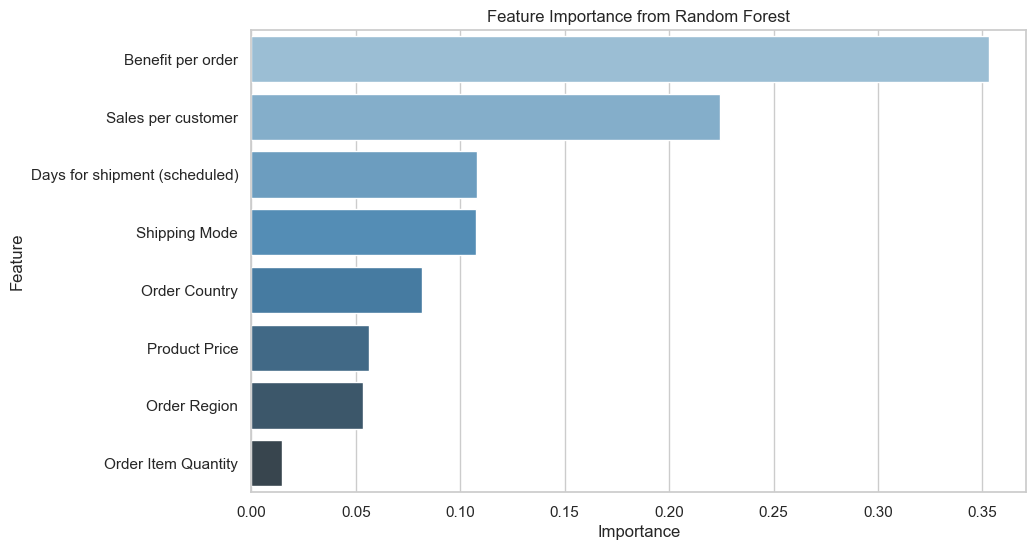

In [26]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest on the scaled training set
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get feature importance from the Random Forest model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  # Ensure this matches your feature names
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the feature importance values
print(feature_importance)

# Visualize the feature importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Blues_d')
plt.title('Feature Importance from Random Forest')
plt.show()


Objective:
The bar plot visualizes the relative importance of each feature in predicting the target variable (e.g., "Late Delivery Risk") using the Random Forest model.

Key Insights:

Top Features:

- Benefit per Order: The most influential feature, suggesting profitability strongly correlates with delivery risk.
- Sales per Customer: Also significantly impacts predictions, indicating that customer purchase behavior influences late delivery likelihood.

Moderate Influence:

- Days for Shipment (Scheduled) and Shipping Mode: Affect delivery outcomes, likely due to their direct relation to logistics and delivery timelines.

Lower Impact:

- Features like Order Country, Product Price, and Order Region have lesser, though still notable, contributions.
- Order Item Quantity has minimal impact on delivery risk.

Business Implications:
- Understanding the importance of "Benefit per Order" and "Sales per Customer" can help prioritize optimizations in profitability and customer management to mitigate delivery risks.

### Logistic regression coeficient analysis for feature importance

Logistic Regression Coefficients:
                          Feature  Coefficient
0  Days for shipment (scheduled)     0.518817
3                  Product Price     0.013974
4            Order Item Quantity     0.004025
6                   Order Region     0.000920
7                  Order Country     0.000249
1              Benefit per order    -0.009544
2             Sales per customer    -0.019058
5                  Shipping Mode    -1.531717


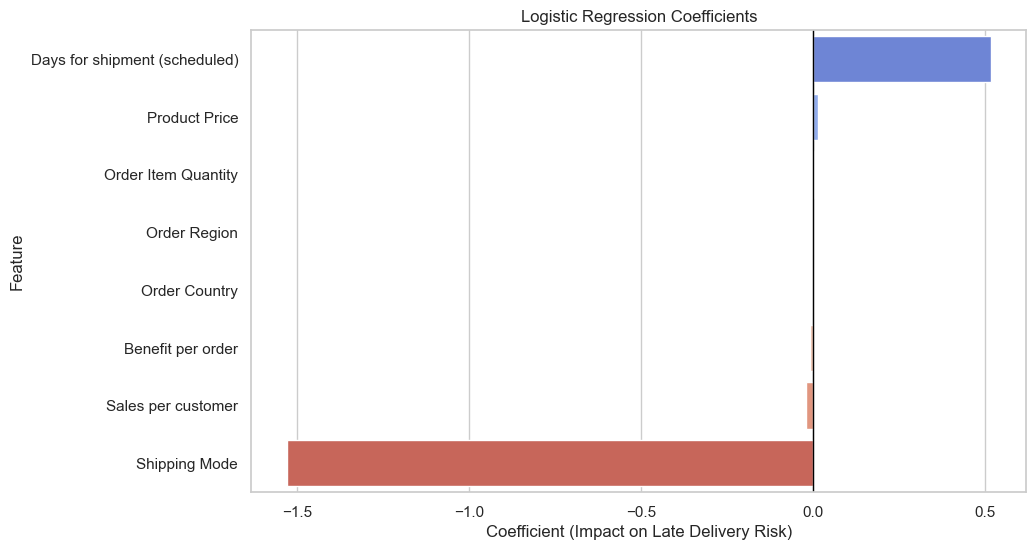

In [28]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Get feature coefficients
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Interpret coefficients: positive means increase in risk, negative means decrease
print("Logistic Regression Coefficients:\n", coefficients)

# Visualize coefficients
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='coolwarm')
plt.title("Logistic Regression Coefficients")
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Coefficient (Impact on Late Delivery Risk)")
plt.ylabel("Feature")
plt.show()



Interpretation of Logistic Regression Coefficients
The coefficients from the Logistic Regression model indicate the direction and magnitude of the relationship between each feature and the likelihood of a late delivery risk (target variable = 1). Here's a breakdown of the results:

Positive Coefficients:

Days for shipment (scheduled) (+0.5188):
A higher number of scheduled days for shipment increases the likelihood of a late delivery. This may indicate that when shipping schedules are extended, delays are more likely to occur due to inefficient planning or fulfillment constraints.
Product Price (+0.0140):
While the impact is small, higher product prices slightly increase the probability of late delivery. Expensive items might require additional handling or quality checks that delay shipments.
Order Item Quantity (+0.0040):
Larger order quantities marginally increase the likelihood of late delivery. This could be due to logistical challenges in packaging and transporting larger orders.
Near-Zero Coefficients (Minimal Impact):

Order Region (+0.0009) and Order Country (+0.0002):
These features have almost no effect on late delivery risk in the model. This suggests that geographical variations (at the region or country level) are not significant predictors of late deliveries.
Negative Coefficients:

Benefit per order (-0.0095):
Higher profit margins slightly decrease the likelihood of a late delivery. Priority may be given to more profitable orders, ensuring they are shipped on time.
Sales per customer (-0.0191):
Increased sales per customer are associated with a reduced probability of late delivery. This may reflect customer prioritization for higher-value clients.
Shipping Mode (-1.5317):
This has the largest negative impact. A change in shipping mode (e.g., from Standard to a faster method) greatly reduces the likelihood of a late delivery. It highlights the importance of choosing the right shipping method to mitigate delays.
Key Insights and Implications:
Operational Focus:

The significant positive impact of Days for shipment (scheduled) suggests that over-scheduling shipments can increase delays, potentially due to inefficiencies in longer lead times. Streamlining operations to optimize shipment schedules could reduce late deliveries.
Shipping Methodology:

Shipping Mode has the strongest negative effect, underlining its critical role in preventing delays. Investments in reliable and faster shipping options (e.g., Same Day or First Class) can significantly mitigate late delivery risks.
Customer Prioritization:

Features like Benefit per order and Sales per customer demonstrate that prioritizing higher-margin and high-value orders can help ensure timely delivery. This could inform strategic decisions about prioritization rules in logistics workflows.
Product Price and Order Size:

Although their effects are smaller, Product Price and Order Item Quantity suggest that special handling for expensive items and large orders can lead to delays. Companies might consider improving processes for these cases, such as dedicated logistics teams or specialized packaging.
Geographical Factors:

Order Region and Order Country have minimal influence, indicating that geography at a high level doesn't drive late deliveries. If finer-grained location data (e.g., cities) were available, they might reveal more localized logistical challenges.
This analysis reinforces the importance of focusing on controllable operational factors—like shipping mode and scheduling—to improve delivery performance while maintaining customer satisfaction. Let me know if you'd like to dive deeper into action plans or further explore these results!

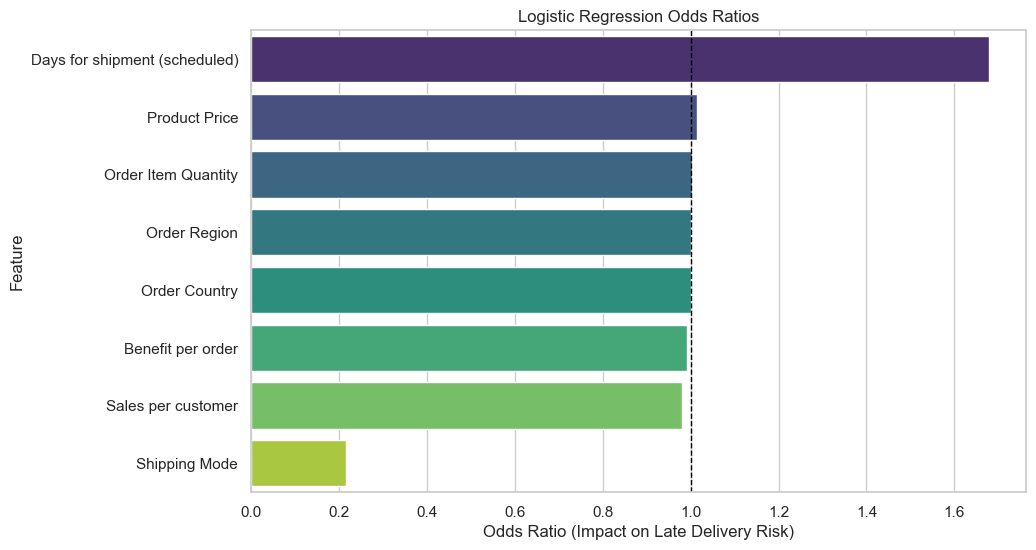

In [49]:
## Logistic Regression Coefficients Converted to Odds ratio

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Convert coefficients to odds ratios
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Odds Ratio': np.exp(lr_model.coef_[0])  # Exponentiate coefficients to get odds ratios
}).sort_values(by='Odds Ratio', ascending=False)

# Visualize odds ratios
plt.figure(figsize=(10, 6))
sns.barplot(x='Odds Ratio', y='Feature', data=coefficients, palette='viridis')
plt.title("Logistic Regression Odds Ratios")
plt.axvline(1, color='black', linewidth=1, linestyle='--')  # Odds ratio of 1 means no effect
plt.xlabel("Odds Ratio (Impact on Late Delivery Risk)")
plt.ylabel("Feature")
plt.show()


Code:

Logistic regression model is trained on scaled data.
Model coefficients are exponentiated to get odds ratios.
Odds ratios are visualized in a bar chart, sorted by magnitude.
Interpretation:

Days for Shipment (Scheduled) has the highest odds ratio, indicating a strong positive impact on late delivery risk.
Shipping Mode has the lowest odds ratio, suggesting it has a negative impact on late delivery risk.
Features with odds ratios greater than 1 increase late delivery risk, while those less than 1 decrease it.

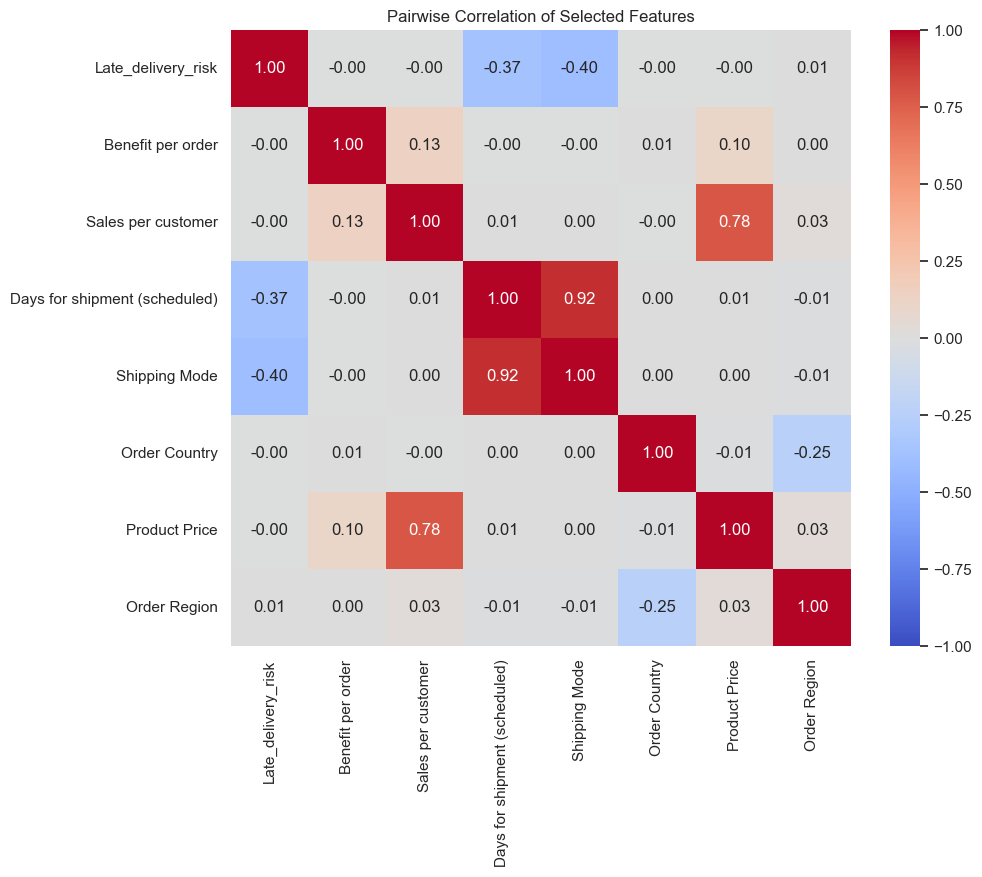

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_cleaned or a similar clean dataset is already defined

# Step 1: Pairwise Correlation Analysis
# Select relevant features for correlation analysis
features = ['Late_delivery_risk', 'Benefit per order', 'Sales per customer', 'Days for shipment (scheduled)', 'Shipping Mode', 'Order Country', 'Product Price', 'Order Region']
filtered_data = data[features].copy()

# Encode categorical variables to numerical for correlation
filtered_data['Shipping Mode'] = filtered_data['Shipping Mode'].astype('category').cat.codes
filtered_data['Order Country'] = filtered_data['Order Country'].astype('category').cat.codes
filtered_data['Order Region'] = filtered_data['Order Region'].astype('category').cat.codes

# Calculate correlation matrix and plot
plt.figure(figsize=(10, 8))
correlation_matrix = filtered_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Pairwise Correlation of Selected Features")
plt.show()

Strong Correlation between Days for Shipment (Scheduled) and Shipping Mode (0.92):

This high positive correlation suggests that the scheduled shipment days are strongly tied to the type of shipping mode selected. Certain shipping modes likely have predefined shipping timelines, with expedited modes having shorter scheduled days and standard modes having longer schedules.
This implies that “Shipping Mode” is a key feature influencing delivery timing expectations and may be useful in predicting late deliveries.
Moderate Correlation between Sales per Customer and Product Price (0.78):

There’s a moderately strong positive correlation between “Sales per Customer” and “Product Price,” suggesting that higher-priced products contribute to higher overall sales per customer. This relationship could be due to customers purchasing fewer, high-value items rather than multiple lower-priced items.
This insight might indicate that premium product segments drive more revenue per customer, which could influence inventory and pricing strategies.

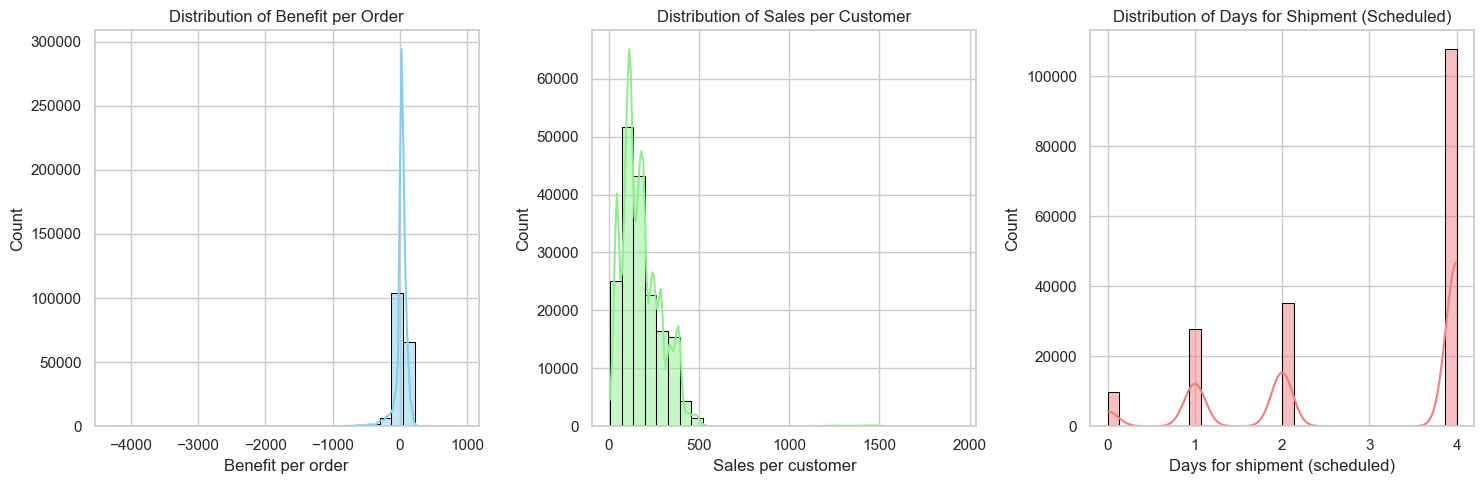

In [30]:
# Step 2: Distribution Analysis of Key Features
# Benefit per order
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['Benefit per order'], kde=True, bins=30, color="skyblue", edgecolor='black')
plt.title("Distribution of Benefit per Order")

# Sales per customer
plt.subplot(1, 3, 2)
sns.histplot(data['Sales per customer'], kde=True, bins=30, color="lightgreen", edgecolor='black')
plt.title("Distribution of Sales per Customer")

# Days for shipment (scheduled)
plt.subplot(1, 3, 3)
sns.histplot(data['Days for shipment (scheduled)'], kde=True, bins=30, color="lightcoral", edgecolor='black')
plt.title("Distribution of Days for Shipment (Scheduled)")

plt.tight_layout()
plt.show()

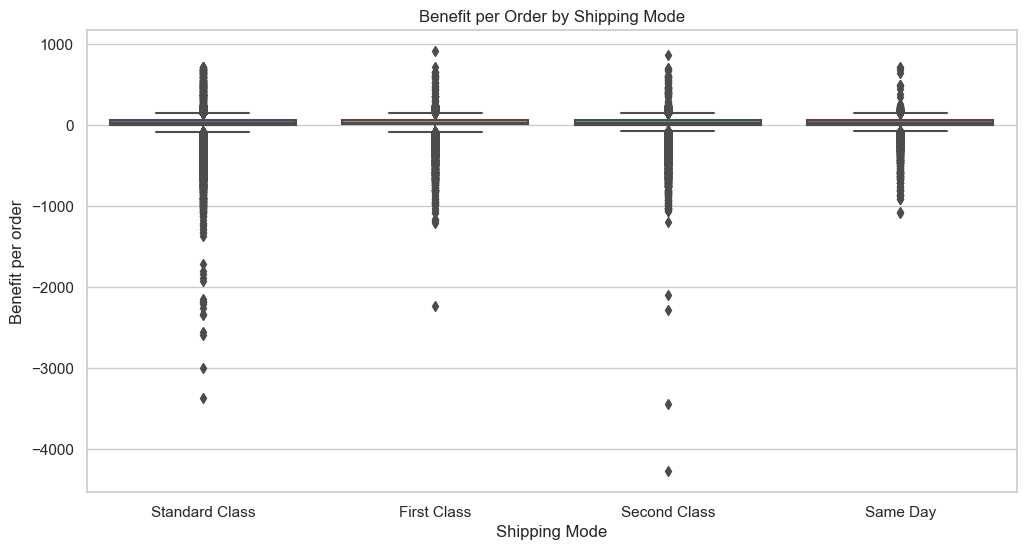

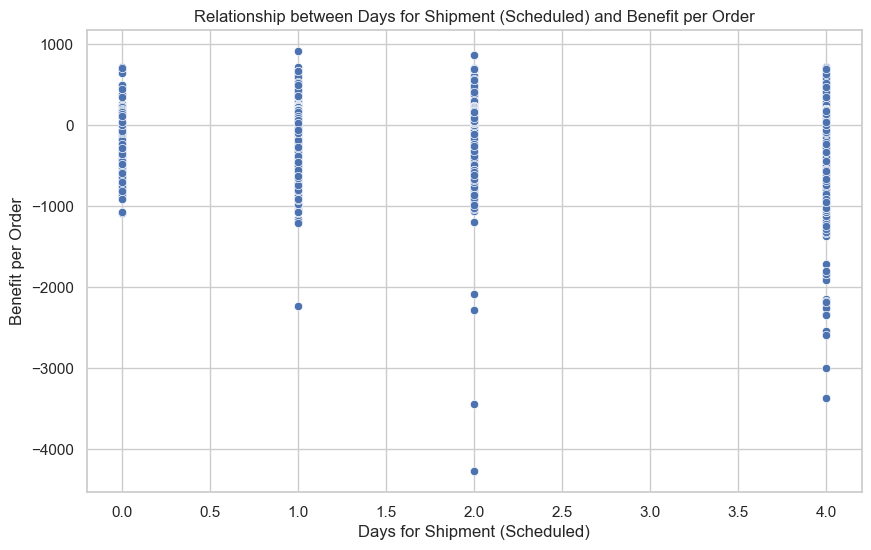

In [31]:
# Step 3: Group Analysis by Shipping Mode and Order Country
# Benefit per order by Shipping Mode
plt.figure(figsize=(12, 6))
sns.boxplot(x='Shipping Mode', y='Benefit per order', data=data)
plt.title("Benefit per Order by Shipping Mode")
plt.show()


# Step 5: Relationship between Days for Shipment (Scheduled) and Benefit per Order
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Days for shipment (scheduled)', y='Benefit per order', data=data)
plt.title("Relationship between Days for Shipment (Scheduled) and Benefit per Order")
plt.xlabel("Days for Shipment (Scheduled)")
plt.ylabel("Benefit per Order")
plt.show()

## Machine Learning Models Evaluation

**Key Metrics Overview:**

- Precision: Proportion of correctly predicted positive instances (class 1) out of all instances predicted as positive.
- High precision minimizes false positives.
- Recall (Sensitivity): Proportion of correctly predicted positive instances (class 1) out of all actual positives.
    - High recall minimizes false negatives.
- F1-Score: Harmonic mean of precision and recall. It balances the two when both are important.
- Accuracy: Proportion of all correctly classified instances.
- ROC-AUC Score: A measure of the model's ability to distinguish between classes. Higher values indicate better overall performance.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = lr_model.predict(X_val_scaled)

# Evaluate the Logistic Regression model
print("Classification Report for Logistic Regression:\n", classification_report(y_val, y_val_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, lr_model.predict_proba(X_val_scaled)[:, 1]))


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.62      0.82      0.70     11455
           1       0.79      0.58      0.67     13818

    accuracy                           0.69     25273
   macro avg       0.70      0.70      0.69     25273
weighted avg       0.71      0.69      0.69     25273

ROC-AUC Score: 0.7092828836355443


/Users/arthurmelo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**1. Logistic Regression:**
Class 0 (Low Risk):

Precision: 0.62 → Among all predictions of class 0, 62% are correct.
Recall: 0.82 → 82% of actual class 0 instances are correctly identified.
F1-Score: 0.70 → Balanced metric for class 0.
Class 1 (High Risk):

Precision: 0.79 → Predictions of high risk are more precise.
Recall: 0.58 → The model misses 42% of actual high-risk cases.
F1-Score: 0.67 → Balanced performance for class 1.
Overall:

Accuracy: 69% of predictions are correct.
ROC-AUC Score: 0.71 → Moderate ability to distinguish between the two classes.
Observations:
Logistic Regression performs well for identifying low-risk cases (high recall for class 0) but struggles to identify high-risk cases (lower recall for class 1).
It might miss high-risk deliveries, which could be costly for the business.

In [33]:
# Predict on the validation set using Random Forest
y_val_pred_rf = rf_model.predict(X_val_scaled)

# Evaluate the Random Forest model
print("Classification Report for Random Forest:\n", classification_report(y_val, y_val_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_val, rf_model.predict_proba(X_val_scaled)[:, 1]))


Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62     11455
           1       0.69      0.64      0.66     13818

    accuracy                           0.64     25273
   macro avg       0.64      0.64      0.64     25273
weighted avg       0.65      0.64      0.64     25273

ROC-AUC Score: 0.7037169522935154


Random Forest:
Class 0 (Low Risk):

Precision: 0.60 → Predictions for class 0 are slightly less precise than Logistic Regression.
Recall: 0.64 → Worse at identifying low-risk cases than Logistic Regression.
F1-Score: 0.62 → Balanced performance for class 0.
Class 1 (High Risk):

Precision: 0.69 → Less precise for class 1 than Logistic Regression.
Recall: 0.64 → Better recall than Logistic Regression for high-risk cases.
F1-Score: 0.66 → Comparable to Logistic Regression for high-risk cases.
Overall:

Accuracy: 64% (lower than Logistic Regression).
ROC-AUC Score: 0.70 (similar to Logistic Regression).
Observations:
Random Forest performs better in identifying high-risk cases (higher recall for class 1) but underperforms on low-risk cases (lower recall for class 0).
Overall accuracy is slightly lower than Logistic Regression.

In [34]:
!pip install xgboost

In [35]:
import xgboost as xgb

# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict on the validation set using XGBoost
y_val_pred_xgb = xgb_model.predict(X_val_scaled)

# Evaluate the XGBoost model
print("Classification Report for XGBoost:\n", classification_report(y_val, y_val_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_val, xgb_model.predict_proba(X_val_scaled)[:, 1]))


Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.61      0.83      0.71     11455
           1       0.80      0.57      0.66     13818

    accuracy                           0.69     25273
   macro avg       0.71      0.70      0.69     25273
weighted avg       0.72      0.69      0.68     25273

ROC-AUC Score: 0.7289475945285848


 XGBoost:
Class 0 (Low Risk):

Precision: 0.61 → Similar to Logistic Regression.
Recall: 0.83 → Matches Logistic Regression for identifying low-risk cases.
F1-Score: 0.71 → Best for class 0.
Class 1 (High Risk):

Precision: 0.80 → Highest among the models for class 1.
Recall: 0.57 → Slightly lower than Random Forest for identifying high-risk cases.
F1-Score: 0.66 → Comparable to the other models for class 1.
Overall:

Accuracy: 69% (similar to Logistic Regression).
ROC-AUC Score: 0.73 → Best among the models.
Observations:
XGBoost provides the best trade-off between identifying low-risk and high-risk cases, with the highest ROC-AUC score.
Slightly better overall performance and precision for high-risk cases make it the best choice among the three models.

**Recommendation:**

Using XGBoost for its higher ROC-AUC score and better overall performance, but monitor recall for high-risk cases. If recall is critical, fine-tune Random Forest or XGBoost hyperparameters to boost sensitivity for class 1.

**Recall is critical when:**

1. High Consequences of False Negatives
    - False negatives occur when the model predicts a low risk (class 0) but the actual case is high risk (class 1). In such scenarios, failing to identify high-risk instances can lead to significant costs or harm.
    Examples:
    - Late Deliveries: If high-risk deliveries (class 1) are missed, it could result in customer dissatisfaction, contract violations, or loss of business reputation.
    - Medical Diagnosis: In healthcare, failing to detect a disease (false negative) can delay treatment and worsen patient outcomes.
    - Fraud Detection: Missing fraudulent activities can lead to financial losses.
    
2. When Every High-Risk Case Demands Attention
If the goal is to ensure that all high-risk cases are flagged, even at the cost of some false positives (where low-risk cases are flagged as high risk).

## Fine tuning

In [36]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],          # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],    # Fraction of samples for fitting each tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features for each tree
    'gamma': [0, 1, 5],              # Minimum loss reduction for a split
    'reg_alpha': [0, 1, 10],         # L1 regularization term
    'reg_lambda': [1, 5, 10]         # L2 regularization term
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=3,               # 3-fold cross-validation
    verbose=1,          # Show progress
    n_jobs=-1           # Use all available CPU cores
)

# Perform the grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

# Refit the best model on the full training data
best_xgb_model = grid_search.best_estimator_

# Evaluate on the validation set
y_val_pred = best_xgb_model.predict(X_val_scaled)
y_val_pred_proba = best_xgb_model.predict_proba(X_val_scaled)[:, 1]

# Metrics for the validation set
from sklearn.metrics import classification_report, roc_auc_score
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation ROC-AUC Score:", roc_auc_score(y_val, y_val_pred_proba))

# Optional: Save the tuned model for future use
import joblib
joblib.dump(best_xgb_model, 'tuned_xgboost_model.pkl')


Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
Best Parameters: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1.0}
Best ROC-AUC Score: 0.7357795964122529
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.87      0.72     11455
           1       0.84      0.55      0.66     13818

    accuracy                           0.69     25273
   macro avg       0.73      0.71      0.69     25273
weighted avg       0.74      0.69      0.69     25273

Validation ROC-AUC Score: 0.7297582515458332


['tuned_xgboost_model.pkl']

Fine-tuning with Grid Search did not significantly improve the performance of the XGBoost model

## Clustering to find patterns

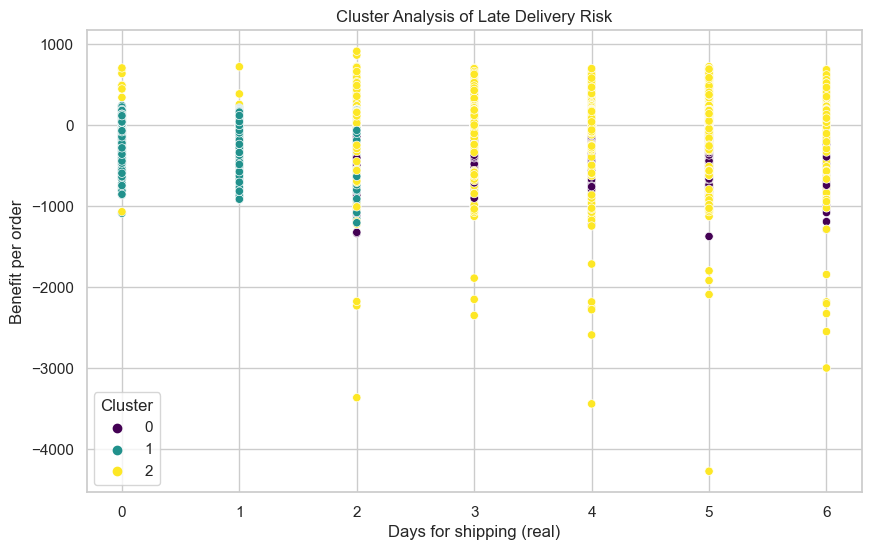

In [37]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Define the essential features for clustering
features = ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 
            'Sales per customer', 'Shipping Mode', 'Order Region', 'Order Country', 'Product Price']

# Create a copy of the data with selected features
data_clustering = data[features].copy()

# Encode categorical features
label_encoders = {}
categorical_features = ['Shipping Mode', 'Order Region', 'Order Country']
for feature in categorical_features:
    le = LabelEncoder()
    data_clustering[feature] = le.fit_transform(data_clustering[feature])
    label_encoders[feature] = le

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_clustering)

# Define the number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

# Analyze each cluster
cluster_summary = data.groupby('Cluster').mean()

# Visualize clusters (optional)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Days for shipping (real)', y='Benefit per order', hue='Cluster', data=data, palette='viridis')
plt.title("Cluster Analysis of Late Delivery Risk")
plt.show()


The scatter plot shows the clustering results based on "Days for shipping (real)" and "Benefit per order." Each color represents a different cluster (Cluster 0, 1, and 2), allowing us to observe distinct patterns in delivery performance based on these features.

Interpretation:
Cluster 0 (Purple):

This cluster appears in the mid to lower range of "Benefit per order" and includes some cases with negative values.
These points are concentrated across different shipping days, suggesting that this group may represent lower-value orders with average or potentially problematic shipping times.
Potential Insight: This cluster might contain orders with less priority in terms of value, potentially resulting in a mixed delivery performance.
Cluster 1 (Teal):

Cluster 1 shows a strong concentration around a "Benefit per order" of 0, with relatively low variance in "Benefit per order" and across all shipping days.
Potential Insight: These could be average or low-priority orders with modest profit margins, not receiving any special treatment in shipping and therefore having more consistent, moderate delivery times.
Cluster 2 (Yellow):

This cluster has a much broader range of "Benefit per order," including both positive and significant negative values. It is also spread across all days for shipping, suggesting a wide variety of order values and shipping times.
Potential Insight: Cluster 2 likely represents high-priority or high-risk orders, which may face delays or expedited processes, as indicated by the wide distribution in profit margins and shipping days.
Summary:
The clusters suggest three general categories of orders:
Cluster 0: Low-value orders with mixed shipping times.
Cluster 1: Consistent, low-to-average-value orders with moderate delivery times.
Cluster 2: High-risk or high-priority orders, showing greater variability in both "Benefit per order" and shipping times.

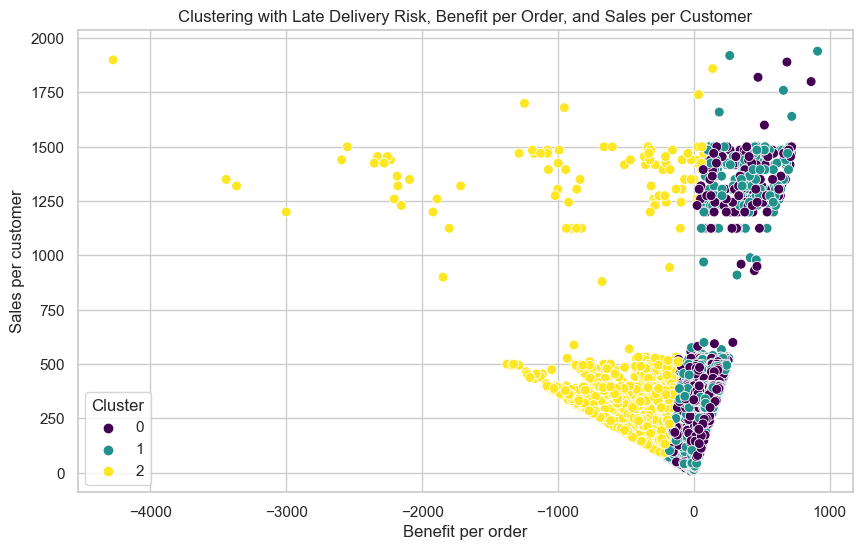

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 2 features and Late_delivery_risk for clustering
features = ['Late_delivery_risk', 'Benefit per order', 'Sales per customer']
data_selected = data[features].copy()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_selected)

# Define the number of clusters (e.g., 3 clusters as an initial guess)
kmeans = KMeans(n_clusters=3, random_state=42)
data_selected['Cluster'] = kmeans.fit_predict(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Benefit per order', y='Sales per customer', hue='Cluster', data=data_selected, palette='viridis', s=50)
plt.title('Clustering with Late Delivery Risk, Benefit per Order, and Sales per Customer')
plt.show()


In this scatterplot showing the clustering results with Late Delivery Risk, Benefit per Order, and Sales per Customer, we observe three distinct clusters:

**Cluster 0 (Purple):**

- This cluster includes data points where Benefit per Order is close to zero or slightly positive and moderate to high Sales per Customer.
- These orders might represent a balance between profitability and customer sales volume, potentially associated with average delivery risk.
- The presence of Late Delivery Risk within this cluster may indicate a mixed delivery outcome.

**Cluster 1 (Teal):**

- Cluster 1 shows points with slightly negative to moderate positive Benefit per Order values and mostly moderate to high Sales per Customer.
    - Orders in this cluster appear to have higher Sales per Customer but vary in profitability.
    - This suggests that orders with decent sales but variable profitability are common in this cluster, which could correspond to average delivery risk, perhaps due to logistical complexities in handling these high-value orders.
    
**Cluster 2 (Yellow):**

- Cluster 2 stands out with highly negative Benefit per Order values and a wide range of Sales per Customer.
- The large number of yellow points scattered across the negative benefit spectrum suggests that these orders are less profitable and may even represent losses.
- These orders likely carry a higher delivery risk, possibly due to cost-cutting measures or lower-priority shipments for non-profitable orders, which may lead to delays.

**Key Insights**

- High-Risk Orders: Cluster 2 likely represents orders that are low or negative in profitability and have varying sales per customer. This could indicate that low-profitability orders are more prone to delivery risk.
- Moderate Delivery Risk: Clusters 0 and 1 have mixed profitability but tend to avoid extreme negative benefits, suggesting that moderately profitable orders may have lower delivery risks.
- Sales Impact: Sales per Customer seems to vary across all clusters but may influence profitability and delivery risk management, as high sales might indicate priority handling.

## ARIMA Forecasting



In [39]:
import pandas as pd

# Assuming 'late_deliveries_time_series' is a time-indexed DataFrame with a 'Late_Delivery' count column
# Step 1: Filter data to the stable period
stable_period_data = late_deliveries_time_series['2015-01':'2017-07']

# Step 2: Resample data to monthly intervals, if necessary
stable_period_data_monthly = stable_period_data.resample('M').sum()


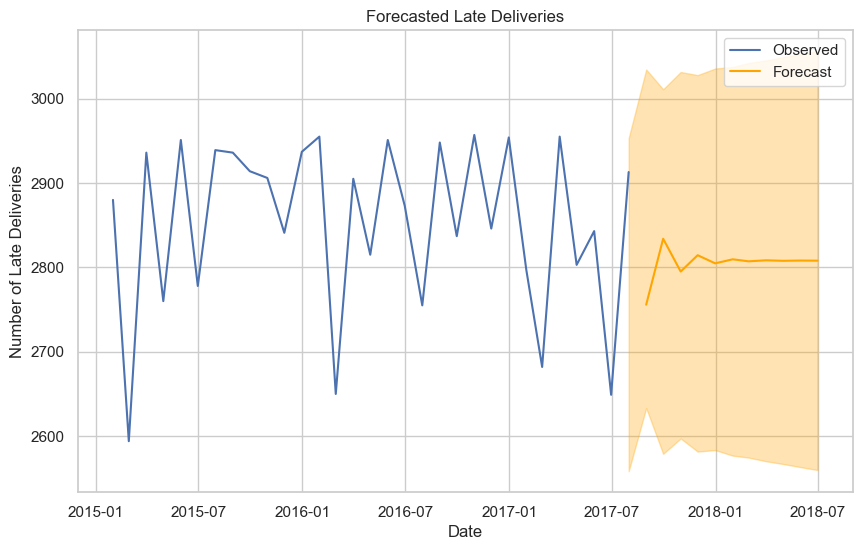

In [40]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model
model = ARIMA(stable_period_data_monthly, order=(1,1,1))  # Modify (p,d,q) as needed
arima_model = model.fit()

# Forecast for the next 12 months as an example
forecast = arima_model.get_forecast(steps=12)
forecast_index = pd.date_range(start=stable_period_data_monthly.index[-1], periods=12, freq='M')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stable_period_data_monthly, label='Observed')
plt.plot(forecast_series, color='orange', label='Forecast')
plt.fill_between(forecast_index, forecast.conf_int()['lower y'], forecast.conf_int()['upper y'], color='orange', alpha=0.3)
plt.title("Forecasted Late Deliveries")
plt.xlabel("Date")
plt.ylabel("Number of Late Deliveries")
plt.legend()
plt.show()



Interpretation:

The ARIMA model forecasts the number of late deliveries for the next 12 months.
The orange line represents the forecasted values, while the blue line shows the actual historical data.
The shaded area in orange indicates the 95% confidence interval of the forecast. It shows the range of values within which the actual number of late deliveries is likely to fall.

In [41]:
print(forecast.conf_int().head())


                lower y      upper y
2017-08-31  2558.388671  2953.168907
2017-09-30  2633.312671  3034.624005
2017-10-31  2579.051447  3011.114482
2017-11-30  2597.241471  3031.601552
2017-12-31  2581.711661  3027.896397


Here's a breakdown of the output:

- lower y: The lower bound of the confidence interval.
- upper y: The upper bound of the confidence interval.

For example, the first row indicates that with 95% confidence, the actual number of late deliveries in August 2017 is expected to be between 2558 and 2953.

Key points to remember:

- A wider confidence interval indicates greater uncertainty in the forecast.
- A narrower confidence interval suggests more precise predictions.
- The confidence level (e.g., 95%) determines the width of the interval. A higher confidence level leads to a wider interval.

## Half-way forecast

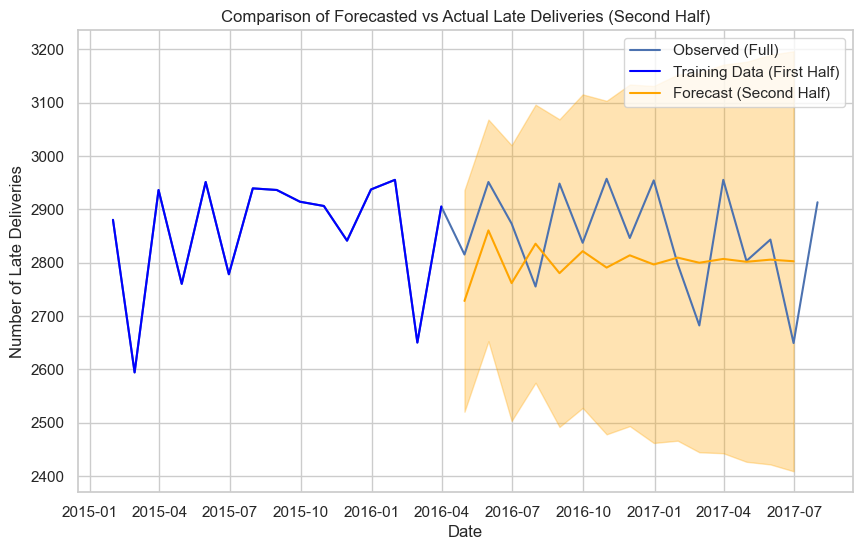

In [42]:
# Step 1: Define a New Timeframe (first half of the stable period)
# Assuming `stable_period_data_monthly` is the dataset used for the initial forecast
halfway_point = len(stable_period_data_monthly) // 2
first_half_data = stable_period_data_monthly[:halfway_point]

# Step 2: Fit a New ARIMA Model on the first half of the data
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on the first half
new_model = ARIMA(first_half_data, order=(1, 1, 1))
new_model_fit = new_model.fit()

# Step 3: Extend the Forecast to mid-2017
forecast_new = new_model_fit.get_forecast(steps=halfway_point)
forecast_new_series = forecast_new.predicted_mean
forecast_new_index = forecast_new_series.index
forecast_new_ci = forecast_new.conf_int()

# Step 4: Plot the new forecast and compare with actuals
plt.figure(figsize=(10, 6))
plt.plot(stable_period_data_monthly, label='Observed (Full)')
plt.plot(first_half_data, label='Training Data (First Half)', color='blue')
plt.plot(forecast_new_series, color='orange', label='Forecast (Second Half)')
plt.fill_between(forecast_new_index, forecast_new_ci['lower y'], forecast_new_ci['upper y'], color='orange', alpha=0.3)
plt.title("Comparison of Forecasted vs Actual Late Deliveries (Second Half)")
plt.xlabel("Date")
plt.ylabel("Number of Late Deliveries")
plt.legend()
plt.show()


#### Analysis of the Forecast

Model Fit on First Half: The blue line represents the training data (first half), where the ARIMA model was fitted. The model seems to capture the overall trend reasonably well, though it's smoothed out.

Forecasting with Increasing Uncertainty: As we extend the forecast into the second half (orange line), the confidence interval widens, reflecting the model's reduced accuracy over a longer forecasting period. This is typical in time series forecasting, where the model's confidence diminishes as it extrapolates further from the training data.

Comparison to Actuals: The forecasted values lie close to the mean of the observed second half but don’t capture the fluctuations or seasonality (up-and-down movements) present in the actual data. The model’s predictions are smooth, reflecting the average level but not the volatility.

##### Next Steps:

Consider a Seasonal Model: If the observed data has recurring patterns or seasonality, exploring a Seasonal ARIMA (SARIMA) model could improve the fit, especially if the fluctuations are periodic.

Re-evaluate Forecast Interval: For future forecasts, limiting the forecast interval to shorter periods may reduce the expansion of the confidence interval, leading to more reliable predictions in the short term.

Alternative Models: Other models like Exponential Smoothing or Prophet, which handle seasonality and trend decomposition well, might provide better forecasts for data with evident fluctuations.

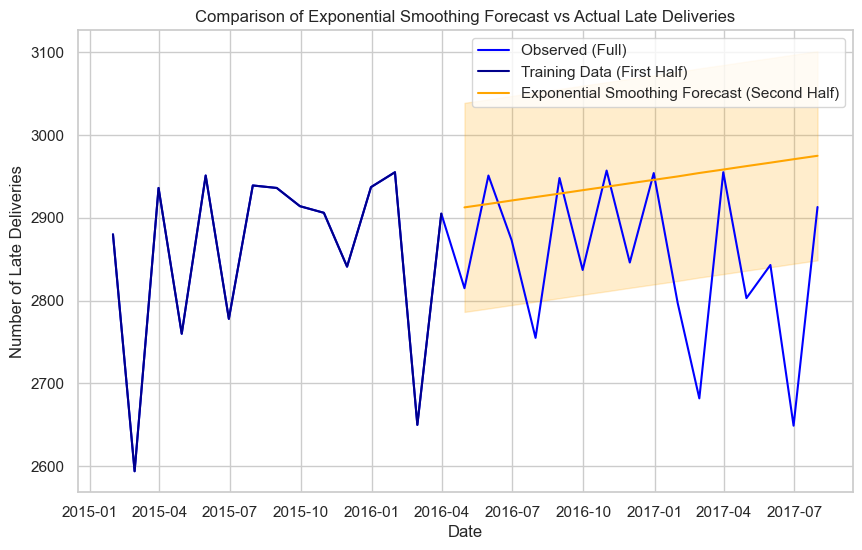

In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_data = stable_period_data_monthly[:int(0.5 * len(stable_period_data_monthly))]
test_data = stable_period_data_monthly[int(0.5 * len(stable_period_data_monthly)):]


# Configure Exponential Smoothing without the seasonal component
exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()

# Forecast the second half
exp_smoothing_forecast = exp_smoothing_model.forecast(steps=len(test_data))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stable_period_data_monthly, label='Observed (Full)', color="blue")
plt.plot(train_data, label='Training Data (First Half)', color="darkblue")
plt.plot(exp_smoothing_forecast, color='orange', label='Exponential Smoothing Forecast (Second Half)')
plt.fill_between(exp_smoothing_forecast.index, exp_smoothing_forecast - exp_smoothing_model.resid.std(), 
                 exp_smoothing_forecast + exp_smoothing_model.resid.std(), color='orange', alpha=0.2)
plt.title("Comparison of Exponential Smoothing Forecast vs Actual Late Deliveries")
plt.xlabel("Date")
plt.ylabel("Number of Late Deliveries")
plt.legend()
plt.show()


In [44]:
!pip install prophet

### Interpretation of the Exponential Smoothing Forecast Graph

Exponential Smoothing is used to forecast late deliveries.
The orange line shows the forecasted values, while the blue line represents the actual data.
The shaded orange area indicates the confidence interval of the forecast.
Comparison with ARIMA

ARIMA might be better suited for capturing long-term trends and seasonality.
Exponential Smoothing is more suitable for short-term patterns and smoothing noise.
Key Considerations

The accuracy of both models depends on data quality and model selection.
Evaluation metrics like MAPE, MSE, and RMSE can be used to assess forecast accuracy.

We will proceed with the Mean Absolute Percent Error (MAPE) for this project since it's the simplest to understand. 

22:20:04 - cmdstanpy - INFO - Chain [1] start processing
22:20:05 - cmdstanpy - INFO - Chain [1] done processing


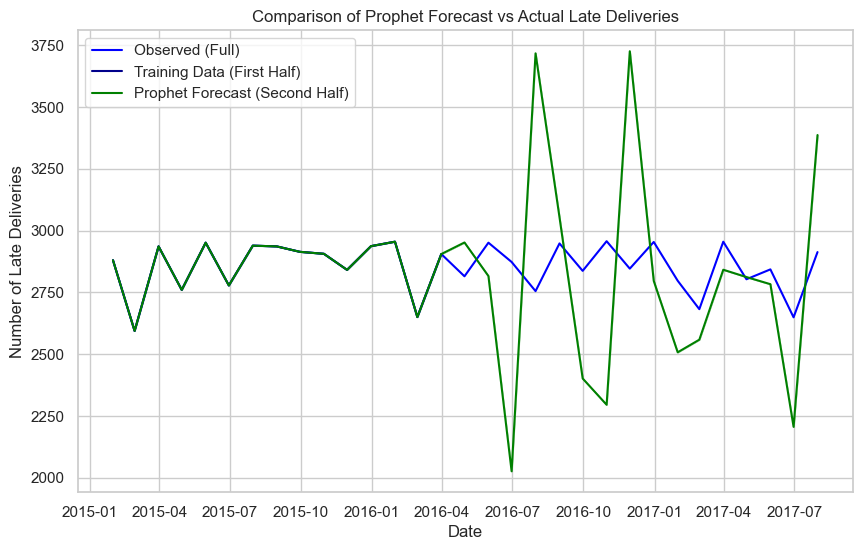

In [45]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_data = stable_period_data_monthly.reset_index()
prophet_data.columns = ['ds', 'y']

# Fit Prophet on the first half
prophet_train_data = prophet_data.iloc[:len(prophet_data)//2]
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_train_data)

# Create a DataFrame to hold the dates for the forecasted period
future_dates = prophet_model.make_future_dataframe(periods=len(prophet_data) - len(prophet_train_data), freq='M')
prophet_forecast = prophet_model.predict(future_dates)

# Plot the Prophet forecast
plt.figure(figsize=(10, 6))
plt.plot(stable_period_data_monthly, label='Observed (Full)', color="blue")
plt.plot(train_data, label='Training Data (First Half)', color="darkblue")
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], color='green', label='Prophet Forecast (Second Half)')
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='green', alpha=0.2)
plt.title("Comparison of Prophet Forecast vs Actual Late Deliveries")
plt.xlabel("Date")
plt.ylabel("Number of Late Deliveries")
plt.legend()
plt.show()


Prophet Forecast Comparison

Prophet is used to forecast late deliveries.
The green line shows the forecasted values, while the blue line represents the actual data.

Comparison with ARIMA and Exponential Smoothing

Prophet is designed for time series data with trend and seasonality.
It often performs well in capturing complex patterns and making accurate forecasts.
However, its performance can be impacted by the quality and quantity of data.

Key Considerations

The choice of forecasting method depends on the specific characteristics of the data.
Model evaluation metrics are crucial for assessing forecast accuracy (MAPE).

## Forecast accuracy

In [46]:
# Assume stable_period_data_monthly is the full dataset used initially
# Split data halfway for training and testing
halfway_point = len(stable_period_data_monthly) // 2
train_data = stable_period_data_monthly[:halfway_point]  # First half for training
test_data = stable_period_data_monthly[halfway_point:]   # Second half for testing (actuals for comparison)

In [47]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for Exponential Smoothing model
mape_exp_smoothing = mean_absolute_percentage_error(test_data, exp_smoothing_forecast)
print(f"MAPE for Exponential Smoothing model: {mape_exp_smoothing:.2f}%")

# Extract the forecasted values for the second half
prophet_forecast_second_half = prophet_forecast.iloc[len(prophet_train_data):]['yhat']

# Align the index to ensure comparison with the test data
prophet_forecast_second_half.index = test_data.index

# Calculate MAPE for Prophet model
mape_prophet = mean_absolute_percentage_error(test_data, prophet_forecast_second_half)
print(f"MAPE for Prophet model: {mape_prophet:.2f}%")

MAPE for Exponential Smoothing model: 3.80%
MAPE for Prophet model: 12.85%


In [48]:
import numpy as np
import pandas as pd

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0  # Exclude zero values to avoid division by zero
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

# Step 1: Prepare train and test data
halfway_point = len(stable_period_data_monthly) // 2
train_data = stable_period_data_monthly[:halfway_point]
test_data = stable_period_data_monthly[halfway_point:]

# Ensure there are no NaN values in test_data
test_data = test_data.dropna()

# Step 2: Forecast with ARIMA
forecast_series = arima_model.get_forecast(steps=len(test_data)).predicted_mean

# Align the forecast index with the test data
forecast_series.index = test_data.index  # Match test_data index for proper comparison

# Step 3: Clean Data for MAPE Calculation
# Remove any remaining NaN or mismatched data points
combined = pd.concat([test_data, forecast_series], axis=1).dropna()
test_data_cleaned = combined.iloc[:, 0]  # Actual values
forecast_series_cleaned = combined.iloc[:, 1]  # Forecasted values

# Step 4: Calculate MAPE for ARIMA
mape_arima = mean_absolute_percentage_error(test_data_cleaned, forecast_series_cleaned)
print(f"MAPE for ARIMA model: {mape_arima:.2f}%")


MAPE for ARIMA model: 3.07%


## Forecast Performance Summary

Model Performance Comparison

Based on the Mean Absolute Percentage Error (MAPE) metric, we can assess the performance of the three forecasting models:

Exponential Smoothing:

MAPE: 3.80%
Interpretation: The model provides relatively accurate forecasts, with an average error of around 3.8%. It's suitable for short-term forecasting and smoothing out noise in the data.

Prophet:

MAPE: 12.85%
Interpretation: The model's performance is less accurate compared to Exponential Smoothing. It might struggle with the specific characteristics of this dataset, particularly in capturing short-term fluctuations.

ARIMA:

MAPE: 3.07%
Interpretation: ARIMA demonstrates the best performance among the three models, with the lowest MAPE. It's effective in capturing trends and seasonal patterns, making it suitable for this particular dataset.

#### Model Recommendation

Based on the MAPE results, **ARIMA is the recommended model for forecasting late deliveries** in this specific scenario. It provides the most accurate predictions and effectively captures the underlying patterns in the data.

### Final Recommendations for the business

- Prioritize: Streamline efficient delivery processes, aligning premium shipping promises with actual delivery times
- Data Collection: Increase the availability of time series data for deliveries to enhance ARIMA forecasting and XGBoost prediction
- Shipping Mode Focus: Investigate and address the high late delivery risks associated with First Class and Same Day shipping
- Feature Optimization: Leverage key predictors like 'Benefit per Order', 'Sales per Customer', and 'Days for Shipment (scheduled)' for targeted improvements
- Continuous Monitoring: Regularly monitor model performance, especially recall, to ensure accurate identification of potential late deliveries